In [2]:
import numpy as np
import pandas as pd
import csv

import matplotlib as mpl
import matplotlib.pyplot as plt
import math

import openpyxl
import pickle
# import torch

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import mutual_info_regression as MIR
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestRegressor as RFR
from sklearn.linear_model import LinearRegression as LR
from sklearn.model_selection import train_test_split,cross_val_score
import matplotlib.pyplot as plt

from joblib import dump, load
from sklearn import utils
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Lasso
from sklearn.linear_model import LassoCV
from sklearn.svm import SVR
from sklearn.kernel_ridge import KernelRidge
from xgboost import XGBRegressor


from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

# read data

In [3]:
data = pd.read_excel('list-FUC.xlsx')
inputData = np.array(data.iloc[:,2:])
outputData = np.array(data.iloc[:,1])

# hyperparameter optimization

In [24]:
test_size = 0.2
def generateRfrParamGrid(low1,high1,num1,low2,high2,num2):      # 
    param_grid = {
        'n_estimators':np.arange(int(low1),int(high1),int(num1)),
        'max_depth':np.arange(int(low2),int(high2),int(num2))
    }
    return param_grid
param = generateRfrParamGrid(300,500,10,3,7,1)
rfr = RandomForestRegressor()
search = GridSearchCV(rfr,param_grid=param,n_jobs=-1,cv=2)
for i in range(10):
        X_train,X_test,y_train,y_test = train_test_split(inputData,outputData,test_size=test_size,random_state=None)    # Randomly split data                                                                                                                  # 该方法对dataframe也适用
        min_max_scaler = preprocessing.MinMaxScaler()
        X_train=min_max_scaler.fit_transform(X_train)
        X_test=min_max_scaler.fit_transform(X_test)
        y_train=min_max_scaler.fit_transform(y_train.reshape(-1,1)).ravel()   # converts it to a column
        y_test=min_max_scaler.fit_transform(y_test.reshape(-1,1)).ravel()    # converts it to a column       
        search.fit(X_train,y_train)      # fitting
        regr = search.best_estimator_        
        score = regr.score(X_test,y_test)  # score
        if i == 0:
            max_score = score           # at run 0, record R2 and the model at this point
        if i>0:
            if score>max_score:
                choose_regr = regr   

In [25]:
choose_regr

RandomForestRegressor(max_depth=6, n_estimators=370)

In [4]:
best_max_depth = choose_regr.max_depth
best_n_estimators = choose_regr.n_estimators

In [5]:
RFR_ = RFR(n_estimators=best_n_estimators ,max_depth=best_max_depth)
score = []
for i in list(range(1,20,1))+list(range(20,210,10)):
    X_wrapper = RFE(RFR_,n_features_to_select=i,step=50).fit_transform(inputData,outputData)
    once = cross_val_score(RFR_,X_wrapper,outputData,cv=5).mean()
    score.append(once)

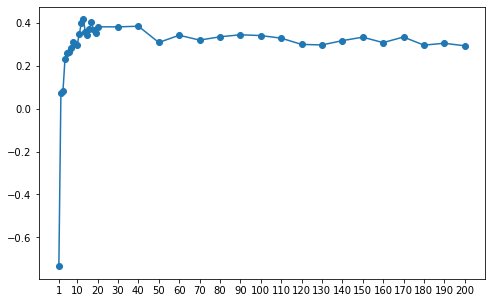

In [6]:
plt.figure(figsize=[8,5])
plt.plot(list(range(1,20,1))+list(range(20,210,10)),score,'o-')
plt.xticks([1]+list(range(10,210,10)))
plt.savefig("list-RFE-processed-feature.png")
plt.show()

In [9]:
B = pd.DataFrame(score)
B.to_csv("list-RFE-R2.csv",index=False,sep=',')

In [7]:
X_wrapper = RFE(RFR_,n_features_to_select=20,step=50).fit_transform(inputData,outputData)

In [8]:
X_wrapper

array([[5.00000000e+00, 5.01700000e+03, 1.93000000e+00, ...,
        1.36020000e+03, 3.00338333e+03, 2.11108571e+03],
       [6.00000000e+00, 2.94400000e+03, 2.13333333e+00, ...,
        1.88270000e+03, 2.86576667e+03, 2.19384286e+03],
       [4.00000000e+00, 4.87600000e+03, 1.79333333e+00, ...,
        1.46122857e+03, 3.10038333e+03, 2.21437143e+03],
       ...,
       [3.00000000e+00, 3.20300000e+03, 1.79000000e+00, ...,
        8.94537143e+02, 2.21038333e+03, 1.59508571e+03],
       [4.00000000e+00, 4.65000000e+03, 2.11000000e+00, ...,
        4.84394286e+02, 2.53412000e+03, 1.52992000e+03],
       [4.00000000e+00, 4.65000000e+03, 1.82666667e+00, ...,
        9.41537143e+02, 2.69271667e+03, 1.80180000e+03]])

In [9]:
X_wrapper.shape

(150, 20)

In [10]:
A = pd.DataFrame(X_wrapper)

In [12]:
A.to_csv("list-RFE.csv",index=False,sep=',')